In [40]:
%env ALL_PROXY=http://127.0.0.1:7897
%env HTTP_PROXY=http://127.0.0.1:7897
%env HTTPS_PROXY=http://127.0.0.1:7897

env: ALL_PROXY=http://127.0.0.1:7897
env: HTTP_PROXY=http://127.0.0.1:7897
env: HTTPS_PROXY=http://127.0.0.1:7897


In [41]:
import tensorflow as tf
from keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import time
import seaborn as sns


In [42]:
np.random.seed(42)
tf.random.set_seed(42)

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12


In [43]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [44]:
X_train.shape, y_train.shape

((50000, 32, 32, 3), (50000, 1))

In [45]:
print(f"训练集形状: {X_train.shape}, 标签形状: {y_train.shape}")
print(f"测试集形状: {X_test.shape}, 标签形状: {y_test.shape}")

训练集形状: (50000, 32, 32, 3), 标签形状: (50000, 1)
测试集形状: (10000, 32, 32, 3), 标签形状: (10000, 1)


In [46]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                'dog', 'frog', 'horse', 'ship', 'truck']
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [47]:
# 数据统计
print(f"像素值范围: [{X_train.min()}, {X_train.max()}]")
print(f"训练集类别分布:")
for i, class_name in enumerate(class_names):
    count = np.sum(y_train == i)
    print(f"  {class_name}: {count} 张")

像素值范围: [0, 255]
训练集类别分布:
  airplane: 5000 张
  automobile: 5000 张
  bird: 5000 张
  cat: 5000 张
  deer: 5000 张
  dog: 5000 张
  frog: 5000 张
  horse: 5000 张
  ship: 5000 张
  truck: 5000 张


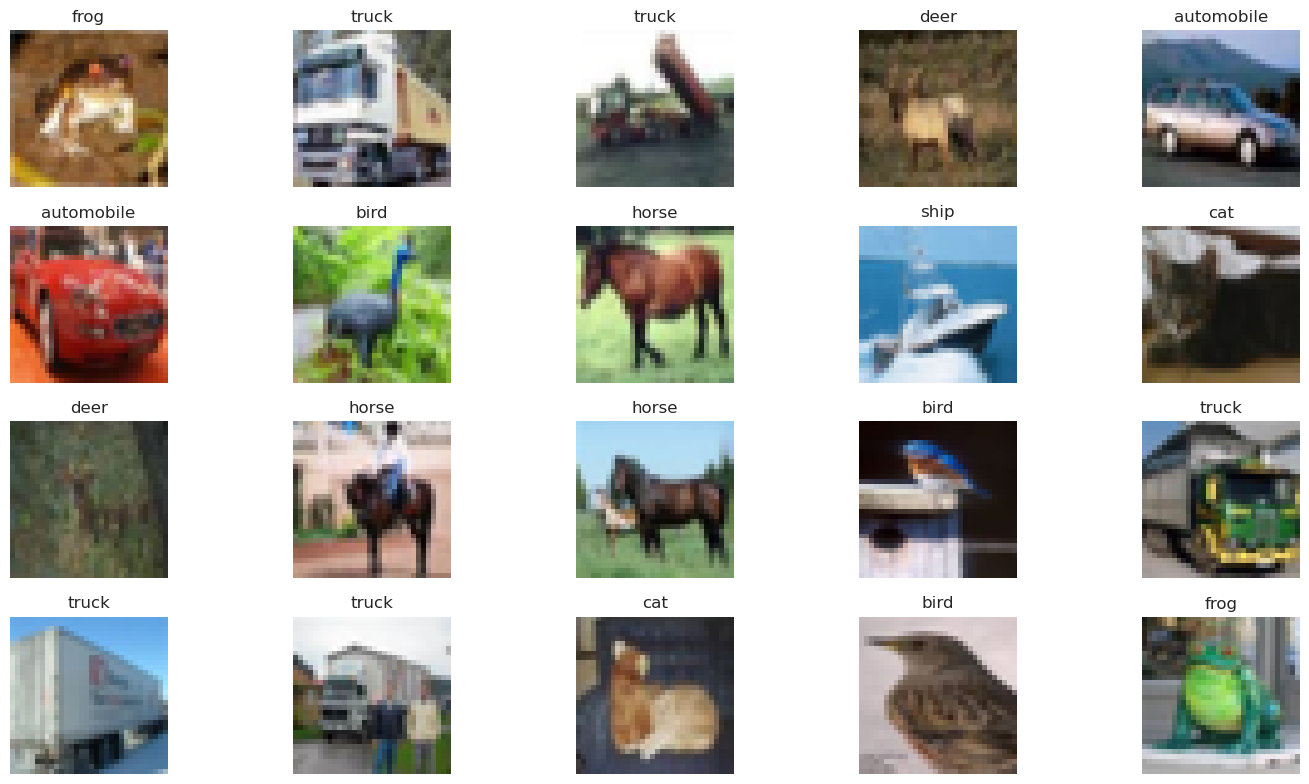

In [ ]:
# 可视化样本图像
plt.figure(figsize=(15, 8))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(X_train[i])
    plt.title(f"{class_names[y_train[i][0]]}")
    plt.axis('off')
plt.tight_layout()
plt.savefig('img/cifar10_samples.png')
plt.show()

In [ ]:
def create_small_samples(X_train, t_train, sample_size=1000, use_pca=True,n_components=50):
    # 随机不放回采样
    indices = np.random.choice(len(X_train), sample_size, replace=False)
    X_sample = X_train[indices]
    y_sample = y_train[indices].flatten()       # 展平
    """
    (5000, 1)被存储为二维数组 [[label1], [label2], ...]
    我们通常需要一维数组 [label1, label2, ...]
    所以需要展平
    """

    # 归一化
    X_sample_normalized = X_sample.astype('float32') / 255.0
    # 展平 (1000, 32,32,3) -> (1000, 3072)
    X_sample_flat = X_sample_normalized.reshape(X_sample_normalized.shape[0], -1)

    # 数据标准化(均值=0，方差=1)
    scaler = StandardScaler()
    X_sample_scaled = scaler.fit_transform(X_sample_flat)

    # PCA降维
    if use_pca:
        pca = PCA(n_components=n_components, random_state=42)
        X_sample_pca = pca.fit_transform(X_sample_scaled)
        print(f"PCA降维后形状: {X_sample_pca.shape}")
        print(f"保留的方差比例: {np.sum(pca.explained_variance_ratio_):.4f}")

        return X_sample_pca, y_sample, scaler, pca
    else:
        return X_sample_scaled, y_sample, scaler, None

    

In [ ]:
X_small, y_small, scaler, pca = create_small_samples(X_train, y_train,sample_size=10000)

PCA降维后形状: (10000, 50)
保留的方差比例: 0.8397


In [51]:
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(
    X_small, y_small, test_size=0.2, random_state=42
)

In [52]:
# 模型性能评估函数
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)

    # 计算指标
    accuracy = accuracy_score(y_test, y_pred)       # 准确率不需要加权平均
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"\n{model_name} 模型评估结果:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [60]:
# 创建SVM模型-线性核，RBF在高维数据上太慢
svm_small = SVC(
    kernel='rbf',
    random_state=42,
    max_iter=1000,
    verbose=True
)
start_time = time.time()
svm_small.fit(X_train_small, y_train_small)
training_time = time.time() - start_time
print(f"✅ SVM训练完成！训练时间: {training_time:.2f}秒")

[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -524.242467, rho = 0.774642
nSV = 850, nBSV = 560
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -604.745428, rho = -0.170822
nSV = 889, nBSV = 618
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -454.307753, rho = 0.304354
nSV = 760, nBSV = 472
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -486.538817, rho = -0.521655
nSV = 728, nBSV = 494
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -456.883536, rho = 0.242275
nSV = 753, nBSV = 482
*
optimization finished, #iter = 927
obj = -350.822682, rho = -0.772340
nSV = 591, nBSV = 374
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -505.840271, rho = 0.346742
nSV = 808, nBSV = 531
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 1000
obj = -786.588642, rho = 0.106067
nSV = 1114, nBS

/home/anemperorduck/anaconda3/envs/tf210/lib/python3.9/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [61]:
svm_metrics_small = evaluate_model(svm_small, X_test_small, y_test_small, "SVM")


SVM 模型评估结果:
Accuracy:  0.4630
Precision: 0.4629
Recall:    0.4630
F1 Score:  0.4616


In [55]:
import joblib
import os
from datetime import datetime

# 创建保存目录
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)

def save_model(model, scaler=None, model_name="model", dataset_name="mnist"):
    """
    保存模型和预处理器到本地
    
    Parameters:
    - model: 训练好的模型 (SVM或MLP)
    - scaler: 预处理器 (StandardScaler等)，可选
    - model_name: 模型名称 (如 "svm", "mlp")
    - dataset_name: 数据集名称
    """
    # 创建唯一的时间戳
    timestamp = datetime.now().strftime("%m%d_%H%M")
    
    # 构建文件名
    model_filename = f"{model_name}_{dataset_name}_{timestamp}.joblib"
    scaler_filename = f"{model_name}_{dataset_name}_scaler_{timestamp}.joblib"
    
    # 完整路径
    model_path = os.path.join(MODEL_DIR, model_filename)
    scaler_path = os.path.join(MODEL_DIR, scaler_filename)
    
    # 保存模型
    joblib.dump(model, model_path)
    print(f"✅ 模型已保存到: {model_path}")
    
    # 保存预处理器（如果存在）
    if scaler is not None:
        joblib.dump(scaler, scaler_path)
        print(f"✅ 预处理器已保存到: {scaler_path}")
    
    return model_path, scaler_path if scaler else None

In [56]:
svm_model_path, svm_scaler_path = save_model(
    model=svm_small,
    scaler=scaler, 
    model_name="svm",
    dataset_name="cifar10_small"
)

✅ 模型已保存到: models/svm_cifar10_small_0105_1748.joblib
✅ 预处理器已保存到: models/svm_cifar10_small_scaler_0105_1748.joblib


In [57]:
# mlp_small = MLPClassifier(
#     hidden_layer_sizes=(512, 256, 128),  # 更深的网络
#     activation='relu',
#     solver='adam',
#     alpha=0.001,  # 更强的L2正则化
#     batch_size=64,
#     learning_rate='adaptive',
#     learning_rate_init=0.001,  # 明确设置学习率
#     max_iter=2000,
#     random_state=42,
#     verbose=True,  # 查看训练过程
#     early_stopping=True,
#     validation_fraction=0.2,  # 更多验证数据
#     n_iter_no_change=20,
#     beta_1=0.9,  # Adam参数
#     beta_2=0.999,
#     epsilon=1e-8
# )


mlp_small = MLPClassifier(
    hidden_layer_sizes=(512, 256, 128),  # 增加深度
    activation='relu',
    solver='adam',
    alpha=0.001,  # 增加正则化防止过拟合
    batch_size=64,
    learning_rate='adaptive',
    learning_rate_init=0.001,  # 明确设置学习率
    max_iter=2000,
    random_state=42,
    verbose=True,  # 查看训练过程
    early_stopping=True,
    validation_fraction=0.2,  # 增加验证比例
    n_iter_no_change=20,
    tol=1e-4
)



start_time = time.time()
mlp_small.fit(X_train_small, y_train_small)
training_time = time.time() - start_time
print(f"✅ MLP训练完成！训练时间: {training_time:.2f}秒")

Iteration 1, loss = 1.99851849
Validation score: 0.359375
Iteration 2, loss = 1.58794290
Validation score: 0.363125
Iteration 3, loss = 1.41124987
Validation score: 0.397500
Iteration 4, loss = 1.24351400
Validation score: 0.404375
Iteration 5, loss = 1.07640045
Validation score: 0.411250
Iteration 6, loss = 0.94417775
Validation score: 0.401875
Iteration 7, loss = 0.77239600
Validation score: 0.400625
Iteration 8, loss = 0.63125781
Validation score: 0.376875
Iteration 9, loss = 0.48224913
Validation score: 0.388750
Iteration 10, loss = 0.36593491
Validation score: 0.387500
Iteration 11, loss = 0.28418570
Validation score: 0.398125
Iteration 12, loss = 0.21378636
Validation score: 0.400000
Iteration 13, loss = 0.14767243
Validation score: 0.412500
Iteration 14, loss = 0.10828844
Validation score: 0.391250
Iteration 15, loss = 0.14062506
Validation score: 0.407500
Iteration 16, loss = 0.15775797
Validation score: 0.389375
Iteration 17, loss = 0.13205603
Validation score: 0.387500
Iterat

In [58]:
mlp_metrics_small = evaluate_model(mlp_small, X_test_small, y_test_small, "MLP")


MLP 模型评估结果:
Accuracy:  0.4240
Precision: 0.4238
Recall:    0.4240
F1 Score:  0.4225


In [59]:
mlp_model_path, mlp_scaler_path = save_model(
    model=mlp_small,
    scaler=scaler,
    model_name="mlp", 
    dataset_name="cifar10_small"
)

✅ 模型已保存到: models/mlp_cifar10_small_0105_1749.joblib
✅ 预处理器已保存到: models/mlp_cifar10_small_scaler_0105_1749.joblib


In [66]:
def plot_mlp_training_curves(mlp_model, model_name="MLP"):
    """
    绘制MLP训练曲线
    """
    if not hasattr(mlp_model, 'loss_curve_'):
        print("⚠️  MLP模型没有loss_curve_属性，无法绘制训练曲线")
        return
    
    plt.figure(figsize=(12, 6))
    
    # 绘制损失曲线
    plt.plot(mlp_model.loss_curve_, 'b-', linewidth=2, label='训练损失')
    plt.title(f'{model_name} loss curve', fontsize=14)
    plt.xlabel('迭代次数')
    plt.ylabel('损失值')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    timestamp = datetime.now().strftime("%m%d_%H%M%S")
    plt.savefig(f'img/{model_name.lower()}_loss_curve_{timestamp}.png')
    plt.show()
    
    print(f"✅ 训练曲线已保存")

/tmp/ipykernel_37827/3658551231.py:19: UserWarning: Glyph 36845 (\N{CJK UNIFIED IDEOGRAPH-8FED}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_37827/3658551231.py:19: UserWarning: Glyph 20195 (\N{CJK UNIFIED IDEOGRAPH-4EE3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_37827/3658551231.py:19: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_37827/3658551231.py:19: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_37827/3658551231.py:19: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_37827/3658551231.py:19: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_37827/3658551231.py:19: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAP

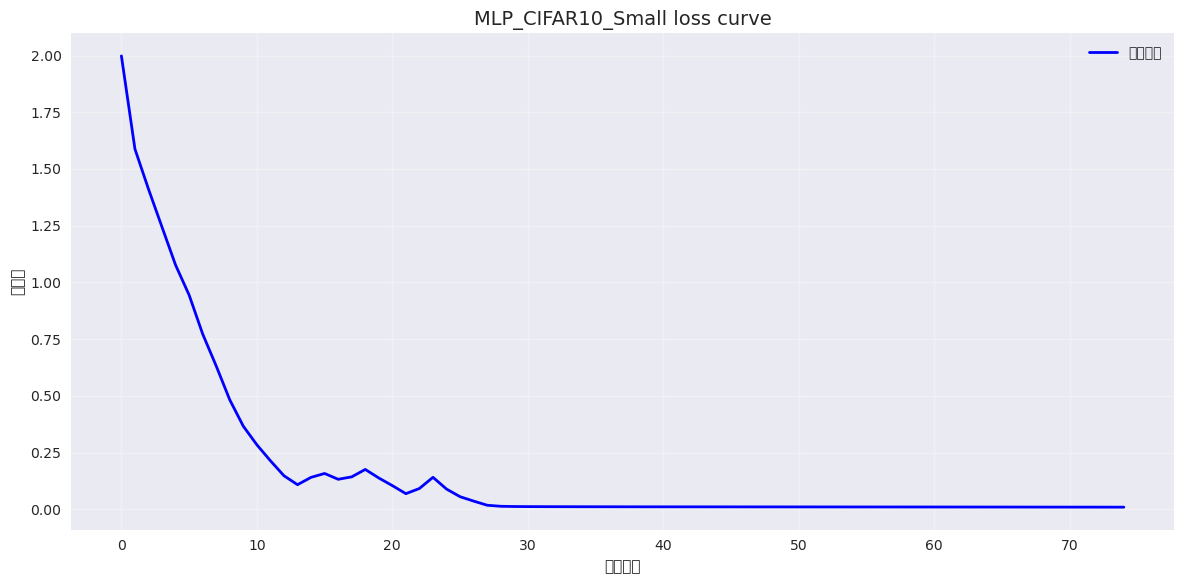

✅ 训练曲线已保存


In [67]:
plot_mlp_training_curves(mlp_small, "MLP_CIFAR10_Small")